In [1]:
!pip install -q qqdm
!pip install -U scikit-learn


In [ ]:
import numpy as np
import random
import torch

from torch.utils.data import DataLoader
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler, TensorDataset) # 导入随机采样器,顺序采样器,将多个张量包装成数据集的数据集类

import torchvision.transforms as transforms


In [ ]:
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
import torchvision.models as models

from torch.optim import Adam, AdamW

from sklearn.cluster import MiniBatchKMeans # K-Means聚类算法的变种适用于大数据集
from scipy.cluster.vq import vq, kmeans # kmeans: 实现基本的K-Means聚类算法, vq: 将数据点分配到最近的聚类中心

from qqdm import qqdm, format_str # format_str 用于自定义进度条的显示格式
import pandas as pd

import pdb # 内置交互式调试工具

In [5]:
train =  np.load("../../Data/data-bin/trainingset.npy", allow_pickle=True)
test = np.load("../../Data/data-bin/testingset.npy", allow_pickle=True)

print(train.shape)
print(test.shape)

(140001, 64, 64, 3)
(19999, 64, 64, 3)


In [8]:
# 检查数据基本信息
print(f"数据类型: {type(train)}")
print(f"数据形状: {train.shape}")  # 通常是 (样本数, 高度, 宽度, 通道) 或 (样本数, 通道, 高度, 宽度)
print(f"第一个样本的形状: {train[0].shape}")
print(f"数据取值范围: {np.min(train)}, {np.max(train)}")  # 通常是 [0, 255] 或 [0, 1]

数据类型: <class 'numpy.ndarray'>
数据形状: (140001, 64, 64, 3)
第一个样本的形状: (64, 64, 3)
数据取值范围: 0, 255


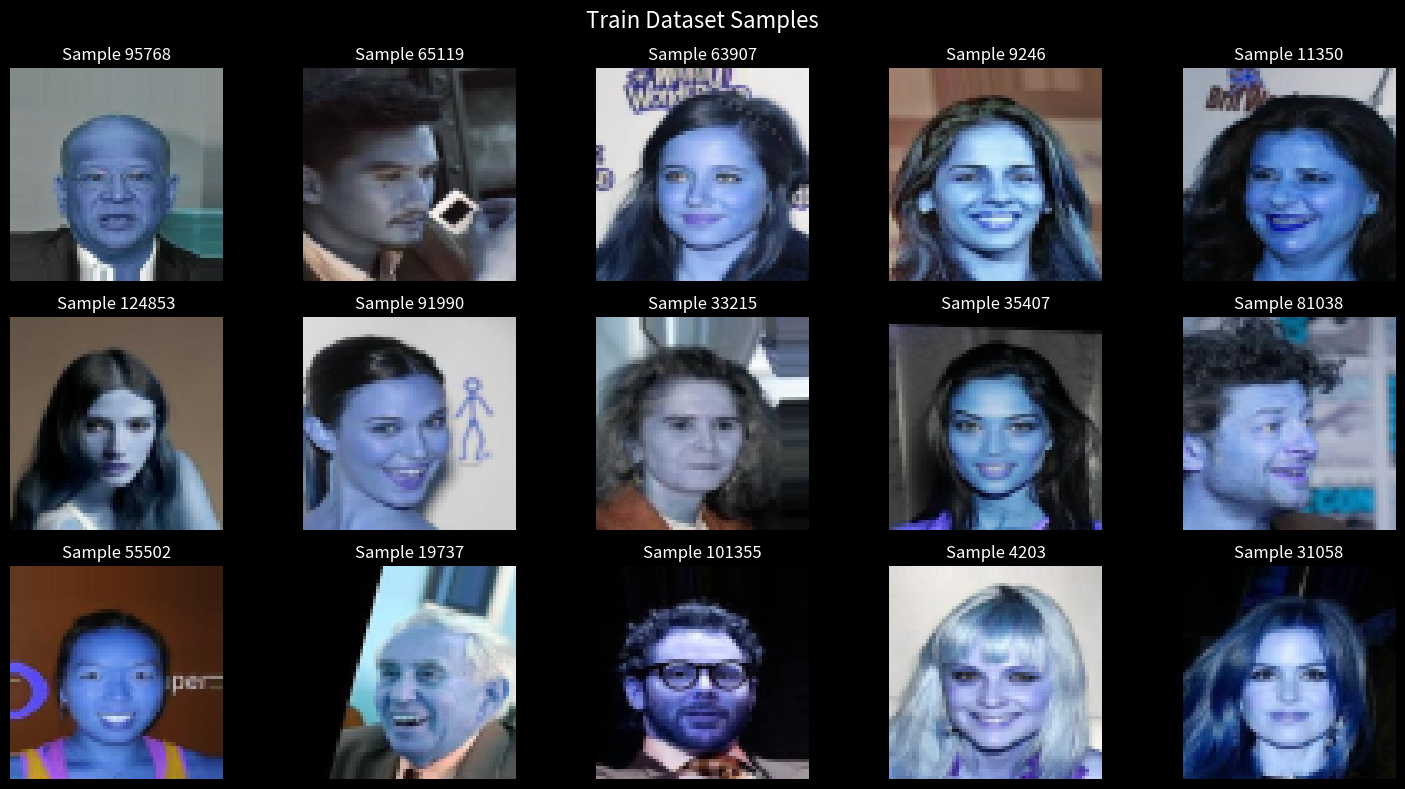

In [13]:
import matplotlib.pyplot as plt

plt.rcParams['font.sans-serif'] = ['Noto Sans CJK JP']

# 设置要展示的图片数量
n_rows = 3  # 行数
n_cols = 5  # 列数
n_images = n_rows * n_cols  # 总图片数

# 随机选择一些图片
indices = np.random.choice(len(train), n_images, replace=False)
selected_images = train[indices]

# 创建画布
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 8))
fig.suptitle("Train Dataset Samples", fontsize=16)

# 遍历并显示每张图片
for i, ax in enumerate(axes.flat):
    if i < n_images:
        img = selected_images[i]
        if img.ndim == 3 and img.shape[0] in [1, 3]:  # (C, H, W) -> (H, W, C)
            img = np.transpose(img, (1, 2, 0))
        if img.ndim == 2 or (img.ndim == 3 and img.shape[-1] == 1):  # 灰度图
            ax.imshow(img.squeeze(), cmap='gray')
        else:  # RGB 图
            ax.imshow(img)
        ax.set_title(f"Sample {indices[i]}")
        ax.axis('off')
    else:
        ax.axis('off')  # 隐藏多余的子图

plt.tight_layout()
plt.show()

In [6]:
def same_seeds(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

same_seeds(2025)

In [ ]:
# 全连接自编码器, 用于图像数据的降维和重建
class fcn_autoencoder(nn.Module):
    def __init__(self):
        super(fcn_autoencoder, self).__init__()
        self.encoder = nn.Sequential( # 将图像压缩到3维空间
            nn.Linear(64 * 64 * 3, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, 12),
            nn.ReLU(True),
            nn.Linear(12, 3)
        )

        self.decoder = nn.Sequential( # 从3维空间重建会原尺寸
            nn.Linear(3, 12),
            nn.ReLU(True),
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 64 * 64 * 3),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [15]:
# 卷积自编码器
class conv_autoencoder(nn.Module):
    def __init__(self):
        super(conv_autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            # 编码器, 压缩图像尺寸和增加通道数 [B, 3, 64, 64] → [B, 96, 4, 4]
            nn.Conv2d(3, 12, 4, stride=2, padding=1),         
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),        
            nn.ReLU(),
			      nn.Conv2d(24, 48, 4, stride=2, padding=1),         
            nn.ReLU(),
            nn.Conv2d(48, 96, 4, stride=2, padding=1),   # medium: remove this layer
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            # 解码器, 转置卷积层向上采样, 恢复图像和减少通道数 [B, 96, 4, 4] → [B, 3, 64, 64]
            nn.ConvTranspose2d(96, 48, 4, stride=2, padding=1), # medium: remove this layer
            nn.ReLU(),
			      nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1), 
            nn.ReLU(),
			      nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [16]:
class VAE(nn.Module):
    # 变分自编码器
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            # 编码器共享部分
            nn.Conv2d(3, 12, 4, stride=2, padding=1),            
            nn.ReLU(),
            nn.Conv2d(12, 24, 4, stride=2, padding=1),    
            nn.ReLU(),
        )
        # TODO: 为什么两个分叉一样的却表示两个不同参数
        self.enc_out_1 = nn.Sequential(
            # 编码器分叉1（均值μ）
            nn.Conv2d(24, 48, 4, stride=2, padding=1),  
            nn.ReLU(),
        )
        self.enc_out_2 = nn.Sequential(
            # 编码器分叉2（对数方差logσ²））
            nn.Conv2d(24, 48, 4, stride=2, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            # 解码器: 通过转置卷积重建图像
			      nn.ConvTranspose2d(48, 24, 4, stride=2, padding=1), 
            nn.ReLU(),
			      nn.ConvTranspose2d(24, 12, 4, stride=2, padding=1), 
            nn.ReLU(),
            nn.ConvTranspose2d(12, 3, 4, stride=2, padding=1), 
            nn.Tanh(),
        )

    def encode(self, x):
        # [B,3,64,64] → mu [B,48,8,8], logvar [B,48,8,8]
        h1 = self.encoder(x)
        return self.enc_out_1(h1), self.enc_out_2(h1)

    def reparametrize(self, mu, logvar):
        # 计算标准差 σ = exp(0.5 * logσ²)
        std = logvar.mul(0.5).exp_()  
        # logvar.mul(0.5) 等价于 0.5*logσ²
        # exp_() 计算 exp(0.5*logσ²) = √σ² = σ

        # 生成随机噪声 ε ~ N(0,1)
        if torch.cuda.is_available():
            eps = torch.cuda.FloatTensor(std.size()).normal_()  # GPU版本
        else:
            eps = torch.FloatTensor(std.size()).normal_()        # CPU版本
        eps = Variable(eps)  # 包装为Variable（兼容旧版PyTorch）

        # 计算 z = μ + ε*σ
        return eps.mul(std).add_(mu)  
        # eps.mul(std) = ε*σ
        # add_(mu) = μ + ε*σ

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparametrize(mu, logvar)
        return self.decode(z), mu, logvar


In [17]:
def loss_vae(recon_x, x, mu, logvar, criterion):
    # 重构损失（MSE）
    mse = criterion(recon_x, x)  # 通常用nn.MSELoss()

    # KL散度损失（KLD）
    KLD_element = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    # 分解计算：
    # mu.pow(2) → μ²
    # .add_(logvar.exp()) → μ² + σ² (因为 σ² = exp(logσ²))
    # .mul_(-1) → -(μ² + σ²)
    # .add_(1) → 1 - μ² - σ²
    # .add_(logvar) → 1 - μ² - σ² + logσ²

    KLD = torch.sum(KLD_element).mul_(-0.5)
    # 求和后乘 -0.5 → -0.5 * Σ(1 - μ² - σ² + logσ²)

    return mse + KLD  # 总损失 = MSE + KLD

In [18]:
class Resnet(nn.Module):
    def __init__(self, fc_hidden1=1024, fc_hidden2=768, drop_p=0.3, CNN_embed_dim=256):
        """基于ResNet-18的自编码器实现
        
        参数:
            fc_hidden1: 第一个全连接层的隐藏单元数 (默认1024)
            fc_hidden2: 第二个全连接层的隐藏单元数 (默认768)
            drop_p: Dropout概率 (未在本实现中使用)
            CNN_embed_dim: 潜在空间的维度 (默认256)
        """
        super(Resnet, self).__init__()

        # 存储网络参数
        self.fc_hidden1 = fc_hidden1
        self.fc_hidden2 = fc_hidden2
        self.CNN_embed_dim = CNN_embed_dim

        # 定义解码器使用的卷积参数 (虽然定义但未完全使用)
        self.ch1, self.ch2, self.ch3, self.ch4 = 16, 32, 64, 128  # 通道数
        self.k1, self.k2, self.k3, self.k4 = (5,5), (3,3), (3,3), (3,3)  # 卷积核大小
        self.s1, self.s2, self.s3, self.s4 = (2,2), (2,2), (2,2), (2,2)  # 步长
        self.pd1, self.pd2, self.pd3, self.pd4 = (0,0), (0,0), (0,0), (0,0)  # 填充

        # 编码器部分
        # 使用ResNet-18作为主干网络 (移除最后的全连接层)
        resnet = models.resnet18(pretrained=False)
        modules = list(resnet.children())[:-1]  # 移除最后的全连接层
        self.resnet = nn.Sequential(*modules)  # 输出形状: [B, 512, 1, 1]

        # 全连接层部分
        self.fc1 = nn.Linear(resnet.fc.in_features, self.fc_hidden1)  # 512 -> fc_hidden1
        self.bn1 = nn.BatchNorm1d(self.fc_hidden1, momentum=0.01)    # 批归一化
        self.fc2 = nn.Linear(self.fc_hidden1, self.fc_hidden2)       # fc_hidden1 -> fc_hidden2
        self.bn2 = nn.BatchNorm1d(self.fc_hidden2, momentum=0.01)    # 批归一化
        
        # 潜在空间映射层 (注意: 当前实现只有均值μ，没有logσ²，不是完整VAE)
        self.fc3_mu = nn.Linear(self.fc_hidden2, self.CNN_embed_dim)  # fc_hidden2 -> 潜在维度

        # 解码器部分
        # 从潜在空间重建的全连接层
        self.fc4 = nn.Linear(self.CNN_embed_dim, self.fc_hidden2)     # 潜在维度 -> fc_hidden2
        self.fc_bn4 = nn.BatchNorm1d(self.fc_hidden2)                 # 批归一化
        self.fc5 = nn.Linear(self.fc_hidden2, 64 * 4 * 4)            # fc_hidden2 -> 64 * 4 * 4 (展开为图像)
        self.fc_bn5 = nn.BatchNorm1d(64 * 4 * 4)                      # 批归一化
        self.relu = nn.ReLU(inplace=True)                             # ReLU激活函数

        # 转置卷积层 (上采样)
        self.convTrans6 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=64, out_channels=32, 
                              kernel_size=self.k4, stride=self.s4, padding=self.pd4),
            nn.BatchNorm2d(32, momentum=0.01),
            nn.ReLU(inplace=True),  # 输出形状: [B,32,8,8]
        )
        
        self.convTrans7 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=32, out_channels=8, 
                              kernel_size=self.k3, stride=self.s3, padding=self.pd3),
            nn.BatchNorm2d(8, momentum=0.01),
            nn.ReLU(inplace=True),  # 输出形状: [B,8,16,16]
        )
        
        self.convTrans8 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=8, out_channels=3, 
                              kernel_size=self.k2, stride=self.s2, padding=self.pd2),
            nn.BatchNorm2d(3, momentum=0.01),
            nn.Sigmoid()  # 输出归一化到[0,1]范围  # 输出形状: [B,3,32,32]
        )
        
    def encode(self, x):
        """编码过程: 输入图像 -> 潜在空间表示
        
        参数:
            x: 输入图像 [B, C, H, W]
        返回:
            潜在空间表示 (当前实现只有均值μ)
        """
        x = self.resnet(x)  # ResNet主干网络 [B,512,1,1]
        x = x.view(x.size(0), -1)  # 展平 [B,512]

        # 全连接层处理
        if x.shape[0] > 1:  # 只有batch_size>1时才使用批归一化
            x = self.bn1(self.fc1(x))
        else:
            x = self.fc1(x)
        x = self.relu(x)
        
        if x.shape[0] > 1:
            x = self.bn2(self.fc2(x))
        else:
            x = self.fc2(x)
        x = self.relu(x)
        
        x = self.fc3_mu(x)  # 映射到潜在空间 [B,CNN_embed_dim]
        return x

    def decode(self, z):
        """解码过程: 潜在空间表示 -> 重建图像
        
        参数:
            z: 潜在空间表示 [B, CNN_embed_dim]
        返回:
            重建图像 [B, C, H, W]
        """
        # 全连接层处理
        if z.shape[0] > 1:  # 只有batch_size>1时才使用批归一化
            x = self.relu(self.fc_bn4(self.fc4(z)))
            x = self.relu(self.fc_bn5(self.fc5(x))).view(-1, 64, 4, 4)  # 重塑为图像 [B,64,4,4]
        else:
            x = self.relu(self.fc4(z))
            x = self.relu(self.fc5(x)).view(-1, 64, 4, 4)
        
        # 转置卷积上采样
        x = self.convTrans6(x)    # [B,32,8,8]
        x = self.convTrans7(x)    # [B,8,16,16]
        x = self.convTrans8(x)    # [B,3,32,32]
        
        # 双线性插值上采样到64x64
        x = F.interpolate(x, size=(64, 64), mode='bilinear', align_corners=True)
        return x  # 输出形状: [B,3,64,64]

    def forward(self, x):
        """前向传播
        
        参数:
            x: 输入图像 [B, C, H, W]
        返回:
            重建图像 [B, C, H, W]
        """
        z = self.encode(x)          # 编码
        x_reconst = self.decode(z)  # 解码
        return x_reconst

In [ ]:

class CustomTensorDataset(TensorDataset):
    """
        TensorDataset with support of transforms.
    """
    def __init__(self, tensors):
        self.tensors = tensors
        
        # 自动调整维度顺序：若通道在最后一维（H,W,C）→ 转为PyTorch标准格式（C,H,W）
        if tensors.shape[-1] == 3:
            self.tensors = tensors.permute(0, 3, 1, 2) # [B,H,W,C] → [B,C,H,W]
        
        self.transform = transforms.Compose([
                            transforms.Lambda(lambda x: x.to(torch.float32)),
                            transforms.Lambda(lambda x: 2. * x/255. - 1.),  # [0,255] → [-1,1]
                            # transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
                            ])
        
    def __getitem__(self, index):
        x = self.tensors[index]
        
        if self.transform:
            # mapping images to [-1.0, 1.0]
            x = self.transform(x)

        return x

    def __len__(self):
        return len(self.tensors)

In [30]:
# 训练参数配置
num_epochs = 50  # 训练总轮数
batch_size = 10000  # 每个批次的样本数量（注意：这个值非常大，可能需要根据GPU内存调整）
learning_rate = 1e-3  # 学习率

# 数据准备
x = torch.from_numpy(train)  # 将numpy数组转换为PyTorch张量
train_dataset = CustomTensorDataset(x)  # 创建自定义数据集，会自动处理张量维度和归一化

# 数据采样和加载
train_sampler = RandomSampler(train_dataset)  # 创建随机采样器，确保数据随机性
train_dataloader = DataLoader(
    train_dataset, 
    sampler=train_sampler, 
    batch_size=batch_size  # 创建数据加载器，按指定batch_size加载数据
)

# 模型选择与初始化
model_type = 'fcn'  # 选择模型类型（可选：'resnet', 'fcn', 'cnn', 'vae'）
model_classed = {
    'resnet': Resnet(),  # ResNet自编码器
    'fcn': fcn_autoencoder(),  # 全连接自编码器
    'cnn': conv_autoencoder(),  # 卷积自编码器
    'vae': VAE()  # 变分自编码器
}
model = model_classed[model_type].cuda()  # 初始化选定模型并移动到GPU

# 损失函数和优化器
criterion = nn.MSELoss()  # 使用均方误差损失（对于VAE可能需要特殊损失函数）
optimizer = torch.optim.Adam(
    model.parameters(),  # 传入模型参数
    lr=learning_rate  # 设置学习率
)

/home/nullion/anaconda3/envs/pytorch_env/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nullion/anaconda3/envs/pytorch_env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [31]:
# 初始化最佳损失为正无穷，用于跟踪训练过程中的最佳模型
best_loss = np.inf  

# 将模型设置为训练模式（启用dropout/batch norm等训练专用层）
model.train()  

# 使用qqdm创建进度条（替代tqdm），显示训练进度和关键指标
qqdm_train = qqdm(range(num_epochs), desc=format_str('bold', 'Description'))

# 开始训练循环
for epoch in qqdm_train:
    tot_loss = list()  # 存储当前epoch所有batch的损失值
    
    # 遍历数据加载器
    for data in train_dataloader:
        # =================== 数据加载 ====================
        if model_type in ['cnn', 'vae', 'resnet']:
            img = data.float().cuda()  # 转换数据类型并移至GPU
        elif model_type in ['fcn']:
            img = data.float().cuda()
            img = img.view(img.shape[0], -1)  # 全连接网络需要展平输入

        # =================== 前向传播 ====================
        output = model(img)  # 模型推理
        
        # 根据模型类型计算损失
        if model_type in ['vae']:
            # VAE需要特殊损失函数（含KL散度）
            loss = loss_vae(output[0], img, output[1], output[2], criterion)
        else:
            # 普通自编码器使用MSE损失
            loss = criterion(output, img)

        # 记录当前batch的损失
        tot_loss.append(loss.item())

        # =================== 反向传播 ====================
        optimizer.zero_grad()  # 清空梯度缓存
        loss.backward()       # 计算梯度
        optimizer.step()      # 更新参数

    # =================== 保存最佳模型 ===================
    mean_loss = np.mean(tot_loss)  # 计算epoch平均损失
    if mean_loss < best_loss:
        best_loss = mean_loss  # 更新最佳损失
        # 保存当前最佳模型（完整模型结构+参数）
        torch.save(model, 'best_model_{}.pt'.format(model_type))  

    # =================== 日志记录 ===================
    qqdm_train.set_infos({
      'epoch': f'{epoch + 1:.0f}/{num_epochs:.0f}',  # 当前epoch/总epochs
      'loss': f'{mean_loss:.4f}',                   # 平均损失（保留4位小数）
    })

    # =================== 保存最新模型 ===================
    torch.save(model, 'last_model_{}.pt'.format(model_type))  # 每epoch保存

 Iters    Elapsed Time      Speed                                               
 0/50           -             -                                                 
Description   0.0% |                                                           | Iters    Elapsed Time      Speed    epoch   loss                               
 1/50   00:00:05<00:04:25  0.18it/s  1/50   0.3287                              
Description   2.0% |█                                                          | Iters    Elapsed Time      Speed    epoch   loss                               
 2/50   00:00:10<00:04:13  0.19it/s  2/50   0.2361                              
Description   4.0% |██                                                         | Iters    Elapsed Time      Speed    epoch   loss                               
 3/50   00:00:15<00:04:04  0.19it/s  3/50   0.2053                              
Description   6.0% |███                                                        | Iters    Elapsed Time      Spee

In [ ]:
# 设置评估时的批次大小（比训练时小的多，适合内存受限的评估场景）
eval_batch_size = 200  

# ==================== 构建测试数据加载器 ====================
# 将numpy测试数据转换为PyTorch张量，并指定为float32类型（模型输入要求）
data = torch.tensor(test, dtype=torch.float32)  

# 创建自定义测试数据集（会自动应用与训练时相同的预处理）
test_dataset = CustomTensorDataset(data)  

# 使用顺序采样器（不打乱数据，保证评估结果可重现）
test_sampler = SequentialSampler(test_dataset)  

# 创建测试数据加载器
test_dataloader = DataLoader(
    test_dataset,
    sampler=test_sampler,          # 顺序采样
    batch_size=eval_batch_size,    # 小批量评估
    num_workers=1                  # 单进程加载（避免多进程问题）
)

# 定义评估用的损失函数（reduction='none'表示保留每个样本的损失值）
eval_loss = nn.MSELoss(reduction='none')  

# ==================== 加载训练好的模型 ====================
checkpoint_path = 'best_model_fcn.pt'  

# 加载完整模型（weights_only=False允许加载自定义类）
# 注意：需确保环境中已定义fcn_autoencoder类
model = torch.load(checkpoint_path, weights_only=False)  

# 切换模型为评估模式（关闭dropout/batchnorm等训练专用层）
model.eval()  

# 指定预测结果输出文件
out_file = 'PREDICTION_FILE.csv'  

# ====== 实际预测时通常需要添加如下代码 ======
predictions = []
with torch.no_grad():  # 禁用梯度计算以节省内存
    for batch in test_dataloader:
        batch = batch.cuda() if torch.cuda.is_available() else batch
        recon = model(batch)
        
        # 计算每个样本的重建误差（可选）
        loss = eval_loss(recon, batch).mean(dim=[1,2,3])  
        predictions.extend(loss.cpu().numpy())

# 保存预测结果（示例）
import pandas as pd
pd.DataFrame({'reconstruction_error': predictions}).to_csv(out_file, index=False)

In [ ]:
# 存储每个样本的异常分数
anomality = list()  

# 禁用梯度计算（节省内存，加速推理）
with torch.no_grad():  
    # 遍历测试数据
    for i, data in enumerate(test_dataloader): 
        # ============= 数据预处理 =============
        if model_type in ['cnn', 'vae', 'resnet']:
            img = data.float().cuda()  # 常规图像模型
        elif model_type in ['fcn']:
            img = data.float().cuda()
            img = img.view(img.shape[0], -1)  # 全连接网络需展平
        else:
            img = data[0].cuda()  # 兼容其他输入格式

        # ============= 模型推理 =============
        output = model(img)  

        # 处理不同模型的输出
        if model_type in ['cnn', 'resnet', 'fcn']:
            output = output  # 普通自编码器直接输出
        elif model_type in ['res_vae', 'vae']:  
            output = output[0]  # VAE类模型取第一个输出（重建结果）

        # ============= 计算异常分数 =============
        if model_type in ['fcn']:
            # 全连接网络：沿特征维度求和
            loss = eval_loss(output, img).sum(-1)  
        else:
            # 卷积网络：沿通道/空间维度求和
            loss = eval_loss(output, img).sum([1, 2, 3])  

        anomality.append(loss)

# 合并所有batch结果
anomality = torch.cat(anomality, axis=0)  

# 计算RMSE（均方根误差）并转为numpy
anomality = torch.sqrt(anomality).reshape(len(test), 1).cpu().numpy()  

# 保存结果
df = pd.DataFrame(anomality, columns=['Predicted'])
df.to_csv(out_file, index_label='Id')